In [1]:
!pip install statsmodels --upgrade

In [2]:
from google.colab import files
import pandas as pd
import os

uploaded = files.upload()

# Step 3: Save the uploaded file to /content directory
for filename in uploaded.keys():
    filepath = os.path.join("/content", filename)
    with open(filepath, "wb") as f:
        f.write(uploaded[filename])
    print(f"✅ File '{filename}' saved at: {filepath}")

# Step 4 (Optional): Load the file into pandas for verification
try:
    df = pd.read_csv(filepath)
    print(f"\n📊 Successfully loaded {filename}.")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}\n")
    print(df.head())  # Show first few rows
except Exception as e:
    print(f"⚠️ Could not read the file as CSV. Error: {e}")


📤 Please upload your 'timeseries.csv' file:


Saving timeseries1.csv to timeseries1.csv
✅ File 'timeseries1.csv' saved at: /content/timeseries1.csv

📊 Successfully loaded timeseries1.csv.
Shape: (96, 5)
Columns: ['Period', 'Revenue', 'Sales_quantity', 'Average_cost', 'The_average_annual_payroll_of_the_region']

       Period       Revenue  Sales_quantity  Average_cost  \
0  01.01.2015  1.601007e+07         12729.0   1257.763541   
1  01.02.2015  1.580759e+07         11636.0   1358.507000   
2  01.03.2015  2.204715e+07         15922.0   1384.697024   
3  01.04.2015  1.881458e+07         15227.0   1235.606705   
4  01.05.2015  1.402148e+07          8620.0   1626.621765   

   The_average_annual_payroll_of_the_region  
0                                30024676.0  
1                                30024676.0  
2                                30024676.0  
3                                30024676.0  
4                                30024676.0  


In [3]:
import pandas as pd
df = pd.read_csv("/content/timeseries1.csv")

df['date'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')

df_timeseries = df[['date', 'Revenue']].rename(columns={'Revenue': 'timeseries'})

df_timeseries = df_timeseries.sort_values(by='date').reset_index(drop=True)

print(df_timeseries.head())

# Save to a new CSV (optional)
df_timeseries.to_csv("/content/timeseries_clean.csv", index=False)
print("\nSaved as '/content/timeseries_clean.csv'")


        date    timeseries
0 2015-01-01  1.601007e+07
1 2015-02-01  1.580759e+07
2 2015-03-01  2.204715e+07
3 2015-04-01  1.881458e+07
4 2015-05-01  1.402148e+07

✅ Saved as '/content/timeseries_clean.csv'


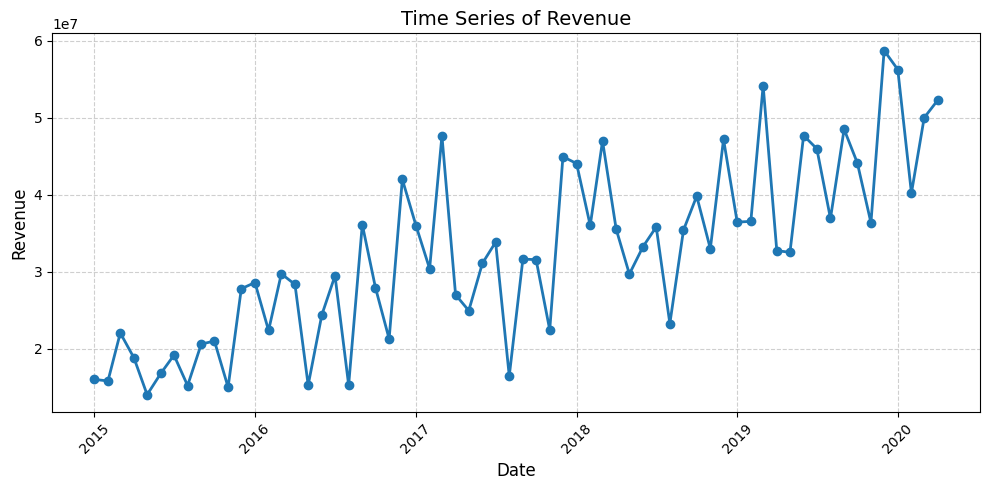

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_timeseries['date'], df_timeseries['timeseries'], marker='o', linewidth=2)

# Add titles and labels
plt.title("Time Series of Revenue", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# STATIONARITY

Notice the data is not stationary (visual inspection).
Let's check.

# Augmented Dickey-Fuller Test

In [5]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Ensure series is sorted by date
df_timeseries = df_timeseries.sort_values('date')

# Extract the series
series = df_timeseries['timeseries']

# Remove NaNs and infinite values
series_clean = series.replace([np.inf, -np.inf], np.nan).dropna()

# Run ADF test
adf_result = adfuller(series_clean, autolag='AIC')

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Number of Lags Used: {adf_result[2]}")
print(f"Number of Observations Used: {adf_result[3]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

ADF Statistic: -0.2691
p-value: 0.9298
Number of Lags Used: 11
Number of Observations Used: 52
Critical Values:
   1%: -3.5629
   5%: -2.9190
   10%: -2.5974


The time series is **non-stationary** (fail to reject H₀). Let's make it stationary!

# First Differencing

In [6]:
# First difference
df_timeseries['timeseries_diff'] = df_timeseries['timeseries'].diff()

# Drop NaNs from differencing
series_diff = df_timeseries['timeseries_diff'].dropna()

# Run ADF test again
adf_result_diff = adfuller(series_diff, autolag='AIC')

print(f"ADF Statistic: {adf_result_diff[0]:.4f}")
print(f"p-value: {adf_result_diff[1]:.4f}")
for key, value in adf_result_diff[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

ADF Statistic: -5.6043
p-value: 0.0000
Critical Value (1%): -3.5629
Critical Value (5%): -2.9190
Critical Value (10%): -2.5974


p-value = 0.0000 <<< 0.05

ADF Statistic < critical values

Our differenced series is stationary!

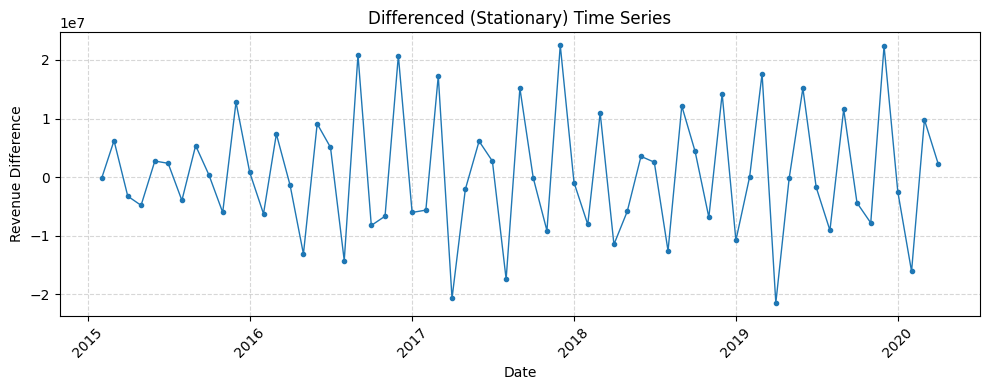

In [7]:
import matplotlib.pyplot as plt

# Create differenced series
df_timeseries['timeseries_diff'] = df_timeseries['timeseries'].diff()

# Drop any NaNs (from differencing or original missing data)
stationary_series = df_timeseries['timeseries_diff'].dropna()

# Align dates with the cleaned differenced series
dates_for_plot = df_timeseries.loc[stationary_series.index, 'date']

# Plot
plt.figure(figsize=(10,4))
plt.plot(dates_for_plot, stationary_series, marker='.', linewidth=1)
plt.title("Differenced (Stationary) Time Series")
plt.xlabel("Date")
plt.ylabel("Revenue Difference")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


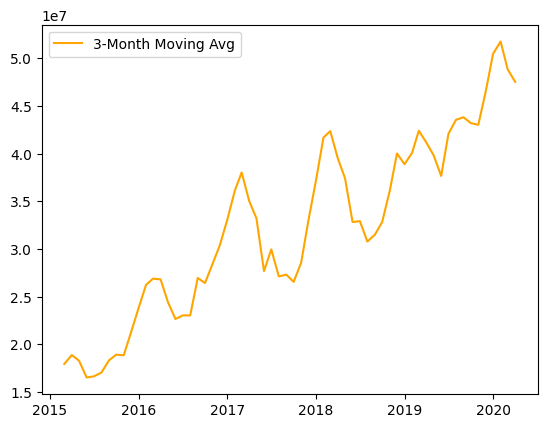

In [8]:
plt.plot(df_timeseries['date'], df_timeseries['timeseries'].rolling(window=3).mean(), color='orange', label='3-Month Moving Avg')
plt.legend()


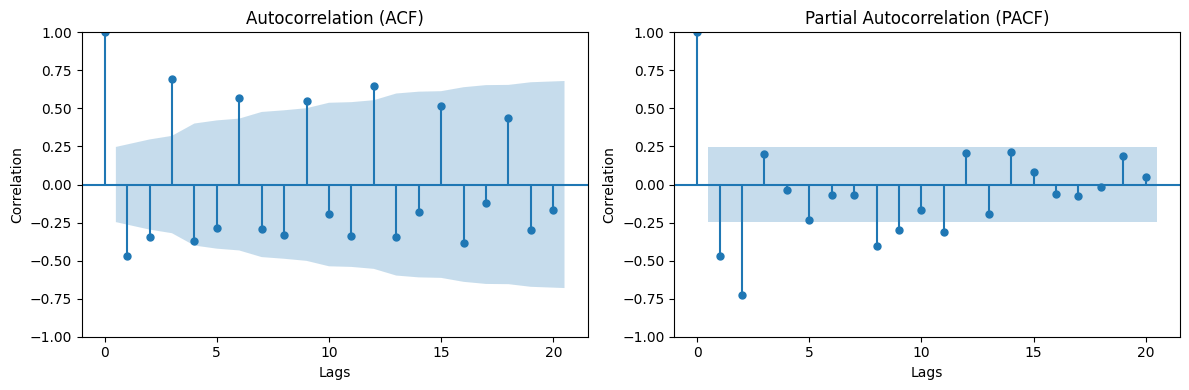

In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use your stationary differenced series
stationary_series = df_timeseries['timeseries_diff'].dropna()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(stationary_series, ax=axes[0], lags=20)
axes[0].set_title("Autocorrelation (ACF)")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("Correlation")

plot_pacf(stationary_series, ax=axes[1], lags=20, method='ywm')
axes[1].set_title("Partial Autocorrelation (PACF)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Correlation")

plt.tight_layout()
plt.show()

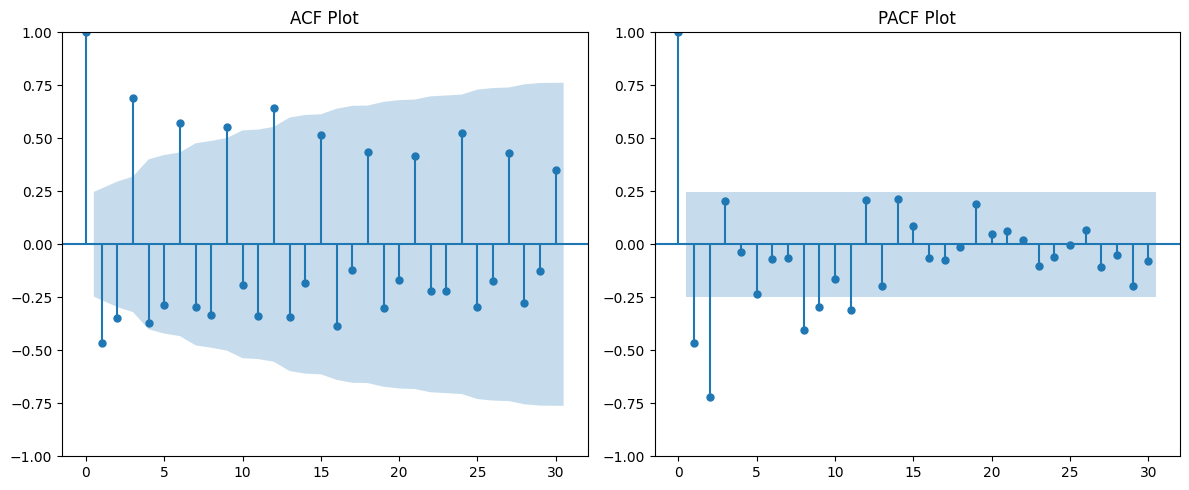

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Automatically pick the max allowed lags (half the series length - 1)
max_lags = min(40, len(stationary_series.dropna()) // 2 - 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(stationary_series.dropna(), lags=max_lags, ax=plt.gca(), title="ACF Plot")

plt.subplot(1, 2, 2)
plot_pacf(stationary_series.dropna(), lags=max_lags, ax=plt.gca(), title="PACF Plot")

plt.tight_layout()
plt.show()


We will use the PACF plot, which is visually more statistically meaningful

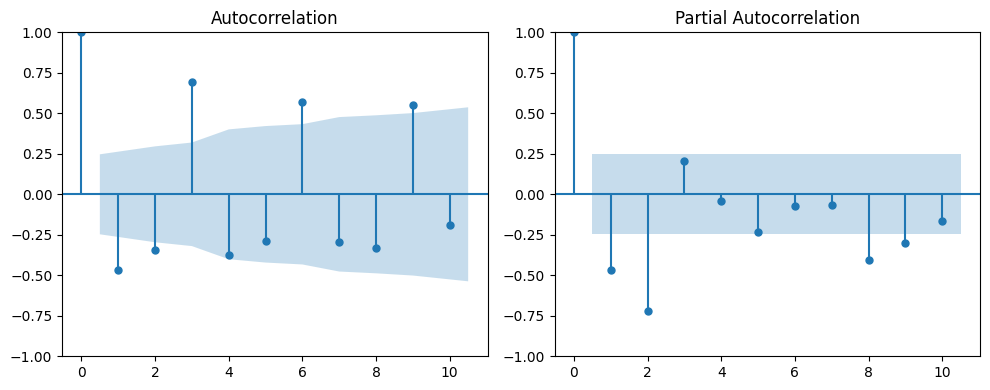

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plot_acf(stationary_series.dropna(), lags=10, ax=plt.gca())

plt.subplot(1, 2, 2)
plot_pacf(stationary_series.dropna(), lags=10, ax=plt.gca())

plt.tight_layout()
plt.show()


In [12]:
train_size = int(len(df_timeseries) * 0.8)

# Split into train and test
train = df_timeseries.iloc[:train_size]
test = df_timeseries.iloc[train_size:]

In [13]:
from statsmodels.tsa.ar_model import AutoReg

train_series = train['timeseries']
test_series = test['timeseries']

In [14]:
import numpy as np

# Remove NaN and infinite values
train_series = train_series.replace([np.inf, -np.inf], np.nan)
train_series = train_series.dropna()

In [15]:
model = AutoReg(train_series, lags=10)
model_fit = model.fit()

In [16]:
print(model_fit.summary())


                            AutoReg Model Results                             
Dep. Variable:             timeseries   No. Observations:                   64
Model:                    AutoReg(10)   Log Likelihood                -911.382
Method:               Conditional MLE   S.D. of innovations        5170674.872
Date:                Thu, 23 Oct 2025   AIC                           1846.765
Time:                        16:57:03   BIC                           1870.633
Sample:                            10   HQIC                          1855.970
                                   64                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.663e+06    3.2e+06      1.459      0.145    -1.6e+06    1.09e+07
timeseries.L1      0.1352      0.127      1.064      0.287      -0.114       0.384
timeseries.L2      0.1740      0.122

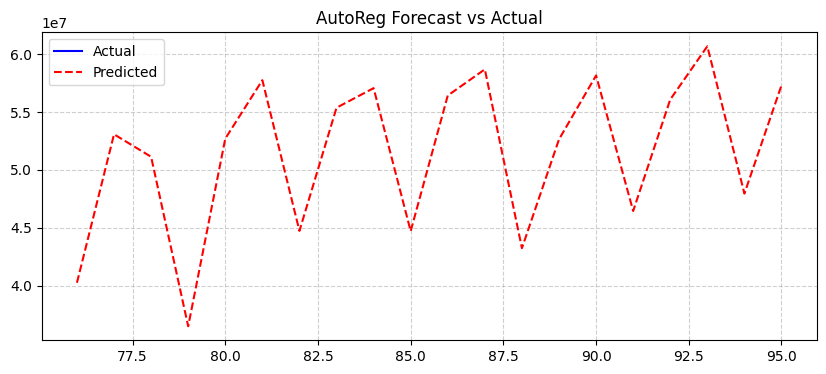

In [17]:
preds = model_fit.predict(start=len(train_series), end=len(train_series)+len(test_series)-1, dynamic=False)

plt.figure(figsize=(10,4))
plt.plot(test_series.index, test_series, label='Actual', color='blue')
plt.plot(test_series.index, preds, label='Predicted', color='red', linestyle='--')
plt.title("AutoReg Forecast vs Actual")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
